## Mouse Kidney Tissue Analysis Using iStar

This analysis applies the iStar method (Zhang et al., 2024) to integrate spatial transcriptomics and histology data, enhancing gene expression resolution and identifying distinct functional regions, demonstrated with mouse kidney tissue.

### 1. Data Description
The dataset features [FFPE mouse kidney tissue sections](https://www.10xgenomics.com/datasets/adult-mouse-kidney-ffpe-1-standard-1-3-0) prepared on Visium Gene Expression slides using 10x Genomics protocols. It is referenced in the iStar paper and shown in Extended Data Fig. 10.


**Histology Image**: The full-resolution TIFF image from the input files is used as **`he-raw.tif`**, with dimensions of 27,443 (width) × 25,260 (height) pixels.

**Dataset Specifications**:   
- Number of spots: 3,124  
- Number of genes: 19,465  
- Pixel size (raw): 0.29 μm
- Radius (raw): 94.33 pixels


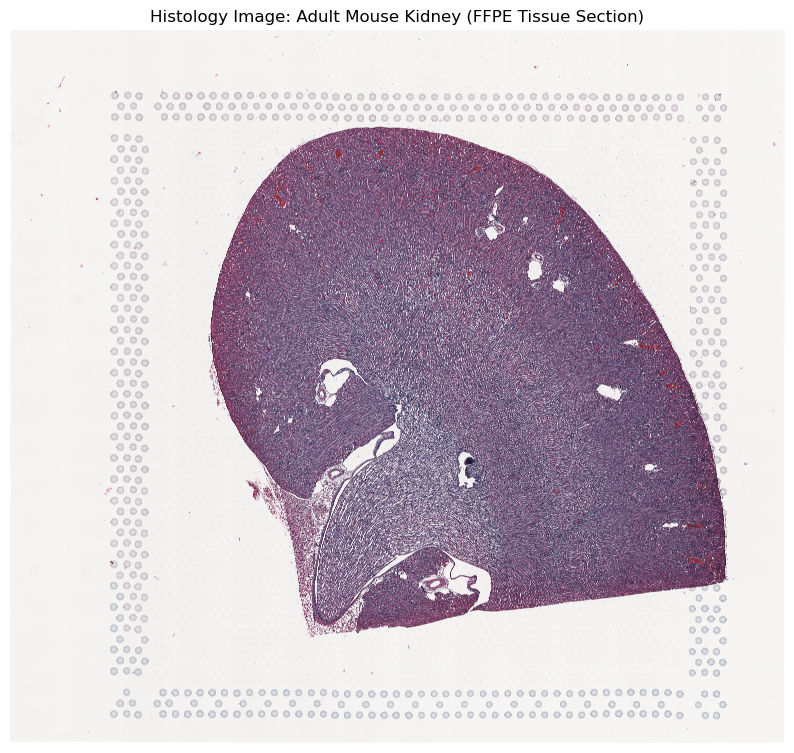

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None
he_raw_image = Image.open('he-raw.tif')

plt.figure(figsize=(10, 10))
plt.imshow(he_raw_image)
plt.axis('off') 
plt.title("Histology Image: Adult Mouse Kidney (FFPE Tissue Section)")
plt.show()

### 2. Image Preprocessing and Feature Embedding

**Pixel Size Setting**: The pixel size for analysis was set to 0.5 μm, meaning each pixel covers 0.5 × 0.5 μm².

**Scaled and Preprocessed Image**: The histology image was resized to 16,128 × 14,848 pixels and padded to ensure dimensions divisible by 256. It was partitioned into 16 non-overlapping 4096 × 4096 tiles for feature extraction using a two-stage HIPT model (Chen et al., 2022).

**Feature Embedding**: 
Each 4096 × 4096 tile was divided into 256 non-overlapping 256 × 256 tiles. These were further split into 16 × 16 subtiles (each representing ~8 × 8 μm², approximating single-cell size). The local ViT processed the 16 × 16 subtiles into low-level features (C2 = 384), while the global ViT aggregated the 256 local features into high-level representations (C1 = 192).
Following the steps described in the iStar paper, the final image embeddings have a shape of (928, 1008, 579):
- 928 × 1008: Subtile grid dimensions derived from the scaled image resolution (16,128 × 14,848 pixels), where the width (16,128) divided by 16 tiles equals 1008, and the height is proportionally 928.
- 579 features: Comprising 192 high-level features, 384 low-level features, and 3 RGB channels for color.

### 3. Mask

To identify the tissue regions containing meaningful spots for training the model, the features extracted from the image were clustered into 2 clusters using KMeans clustering, and small, disconnected regions with fewer than 20 connected pixels were relabeled or removed to ensure spatial coherence. The cluster with the highest variance in RGB values was used as the foreground, creating a binary mask that highlights the foreground regions for future use.

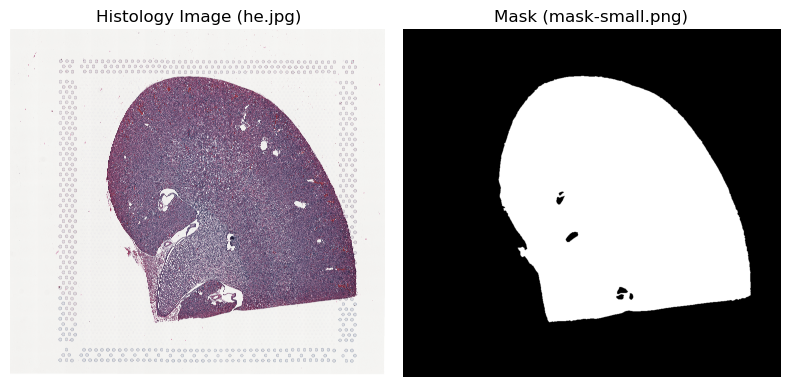

In [14]:
images = [
    ('he.jpg', "Histology Image (he.jpg)"),
    ('mask-small.png', "Mask (mask-small.png)")
]

plt.figure(figsize=(8, 4))
for i, (img_path, title) in enumerate(images, 1):
    img = Image.open(img_path)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

plt.tight_layout()
plt.show()

### 4. Gene Expression Prediction

**Gene Selection for Model Training**: The union of the 1,000 most highly variable genes and 277 marker genes curated from the database Cell Type Selective Markers: RNA-seq Analysis of Mouse Whole Kidney (Clark et al., 2019) was selected for model training. The resulting 1,224 genes correspond to the 1,224 output nodes in the fully connected output layer.

**Observed Spot-level and Predicted Gene Expression**: The following plots illustrate the observed gene expression from the sequencing-based ST platform used for model training (top) and the predicted spatial gene expression (bottom) from the trained model, highlighting different functional regions of the kidney.

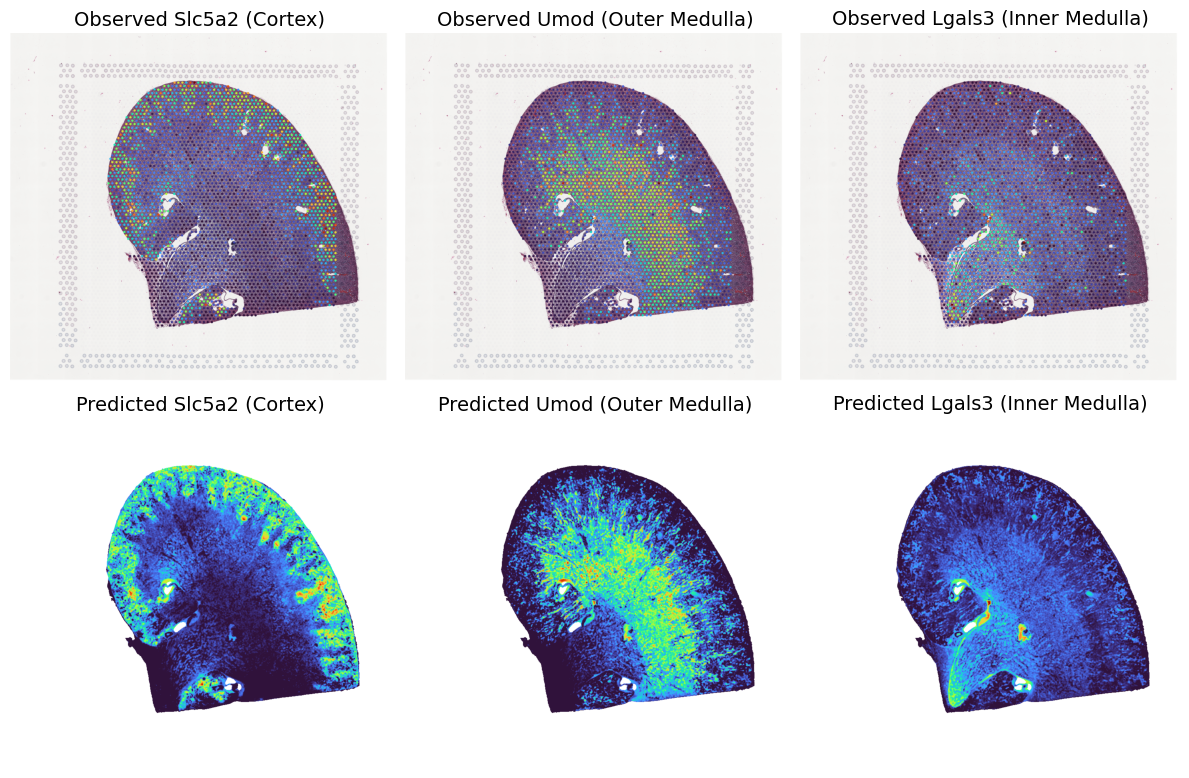

In [8]:
images = [
    ('spots/Slc5a2.png', "Observed Slc5a2 (Cortex)"),
    ('spots/Umod.png', "Observed Umod (Outer Medulla)"),
    ('spots/Lgals3.png', "Observed Lgals3 (Inner Medulla)"),
    ('cnts-super-plots/Slc5a2.png', "Predicted Slc5a2 (Cortex)"),
    ('cnts-super-plots/Umod.png', "Predicted Umod (Outer Medulla)"),
    ('cnts-super-plots/Lgals3.png', "Predicted Lgals3 (Inner Medulla)")
]

plt.figure(figsize=(12, 8))
for i, (img_path, title) in enumerate(images, 1):
    img = Image.open(img_path)
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14)

plt.tight_layout()
plt.show()

### 5. Segmentation

The segmentation process uses the second-last layer of the trained feed-forward neural network as embeddings. To improve spatial continuity and reduce noise, these embeddings are smoothed using a Gaussian filter with an 8-pixel filter size, as illustrated in the comparison of smoothed and unsmoothed embeddings below. KMeans clustering with 10 clusters is applied to segment the tissue. Connected component analysis further refines the segmentation by merging small or isolated regions smaller than 20 pixels with adjacent larger clusters.

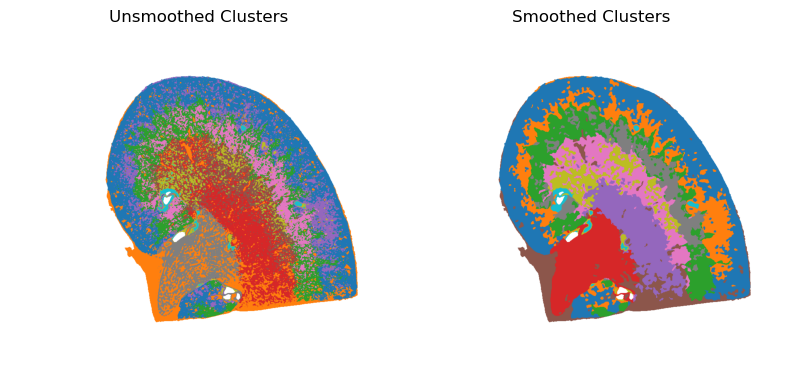

In [13]:
images = [
    ('clusters-gene/unsmoothed/nclusters010/labels.png', "Unsmoothed Clusters"),
    ('clusters-gene/labels.png', "Smoothed Clusters")
]

plt.figure(figsize=(8, 4))

for i, (img_path, title) in enumerate(images, 1):
    img = Image.open(img_path)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

plt.tight_layout()
plt.show()

### References

Zhang, D., Schroeder, A., Yan, H., Yang, H., Hu, J., Lee, M. Y., ... & Li, M. (2024). Inferring super-resolution tissue architecture by integrating spatial transcriptomics with histology. Nature biotechnology, 1-6. 

Chen, R. J., Chen, C., Li, Y., Chen, T. Y., Trister, A. D., Krishnan, R. G., & Mahmood, F. (2022). Scaling vision transformers to gigapixel images via hierarchical self-supervised learning. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 16144-16155).

Clark, J. Z., Chen, L., Chou, C. L., Jung, H. J., Lee, J. W., & Knepper, M. A. (2019). Representation and relative abundance of cell-type selective markers in whole-kidney RNA-Seq data. Kidney international, 95(4), 787-796.